# Data Analyst Job EDA

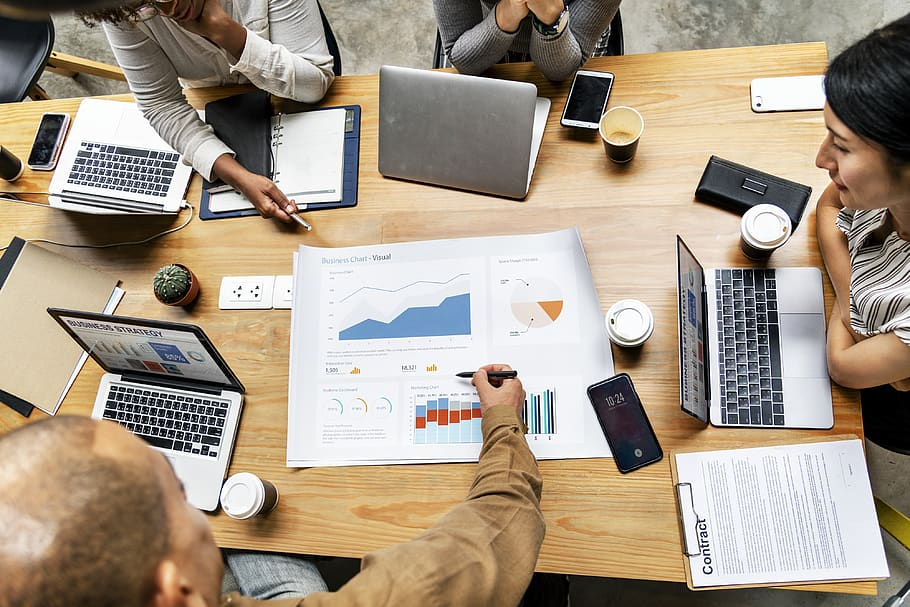

## Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
!pip install chart-studio
import chart_studio.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading the data


In [ ]:
# reading .csv file
df=pd.read_csv('../input/data-analyst-jobs/DataAnalyst.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.shape

Lets take a look at the Data

In [ ]:
df.head()

Dataframe.describe(include='all'), gives us all the required descriptive stats
which include
1. the total number of non NULL values.
2. If it is a categorical variable, the number of unique values in it.
3. Most frequent value in the categorical variable.
4. Descriptive statistics like minimum, maximum, mean, standard deviation, (25-50-75) quantiles.

In [ ]:
df.describe(include='all')

In [ ]:
def miss_val(df):
    #number of missing values
    miss_val = df.isnull().sum()
    
    #percent missing values
    miss_val_per = miss_val/ len(df)*100
    
    #creating df with the results
    miss_val_df = pd.concat([miss_val, miss_val_per], axis=1)
    
    #renaming the columns
    miss_val_df = miss_val_df.rename(columns = {0 : 'missing_values', 1 : '%_of_total_values'})
    
    #sorting the table
    miss_val_df=miss_val_df[miss_val_df['missing_values']!=0]
    miss_val_df = miss_val_df.sort_values('%_of_total_values', ascending=False)
    return miss_val_df

In [ ]:
miss_val(df)

In [ ]:
df['Job Title'].value_counts()

few Job Title got two sections,(The job title and the department) which is separated by ",".

creating two columns by splitting the "Job Title"

In [ ]:
#1 is given as max split i.e split only once
df['Job Title'],df['Department']=df['Job Title'].str.split(',', 1).str
df.head()

In [ ]:
df['Industry'].value_counts().head(10)

### Observations
-1 Indicates null values.

lets explore other columns as well to see if there are such null values(in disguise).

In [ ]:
df['Sector'].value_counts().head(10)

In [ ]:
df['Competitors'].value_counts().head(10)

In [ ]:
df['Easy Apply'].value_counts().head(10)

In [ ]:
df['Revenue'].value_counts().head(10)

### Observations
Similar to the column "Industry", all these columns ("Sector","Competitor","Easy Apply","Revenue") has -1 as the null value.

replacing -1 with null values

In [ ]:
num_lst=[-1,-1.0,'-1']
for num in num_lst:
    df=df.replace(num,np.nan)

In [ ]:
df['Salary Estimate'].value_counts().head(10)

### Observations
"Salary Estimate" has a lot of special characters and text, we only need the estimated number(in integer format).

Removing text(Glassdoor est. ,$, K, -) from the column and splitting it into two columns max and min salary.

In [ ]:
df['Salary Estimate'],_=df['Salary Estimate'].str.split('(', 1).str
df['salary_min'],df['salary_max']=df['Salary Estimate'].str.split('-').str
df['salary_max']=df['salary_max'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')
df['salary_min']=df['salary_min'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0).astype('int')
df.drop('Salary Estimate',axis=1,inplace=True)

In [ ]:
df['Size'].value_counts()

Removing "employees" from the "Size".

In [ ]:
df['Size'],_=df['Size'].str.split(" e").str

In [ ]:
df['Company Name'].value_counts().head(5)

### Observations
"Company Name" has its rating after "\n", which is not required as we already have a Rating column

Removing excess text and only recover company information. 

In [ ]:
df['Company Name'],_=df['Company Name'].str.split('\n', 1).str

"Location" has city and state information.

Splitting it into two individual columns("State", "City")

In [ ]:
df['City'],df['State']=df['Location'].str.split(', ', 1).str
df['State']=df['State'].replace("Arapahoe, CO","CO")
df.drop('Location',axis=1,inplace=True)
df.head()

## Imputing

filling na's.

as model building is not the motive of this Kernel, na's are filled with "Unknown" or 0.

In [ ]:
df['Size'].fillna('Unknown',inplace=True)

df['Founded']=df['Founded'].fillna("0").astype(int)

df['Type of ownership'].fillna('Unknown',inplace=True)

df['Sector'].fillna('Unknown',inplace=True)

df['Easy Apply']=df['Easy Apply'].fillna("False").astype("bool")

Creating a function which will output the maximum Revenue of the company from column "Revenue".

In [ ]:
def filter_revenue(x):
    revenue=0
    if(x== 'Unknown / Non-Applicable' or type(x)==float):
        revenue=0
    elif(('million' in x) and ('billion' not in x)):
        maxRev = x.replace('(USD)','').replace("million",'').replace('$','').strip().split('to')
        if('Less than' in maxRev[0]):
            revenue = float(maxRev[0].replace('Less than','').strip())
        else:
            if(len(maxRev)==2):
                revenue = float(maxRev[1])
            elif(len(maxRev)<2):
                revenue = float(maxRev[0])
    elif(('billion'in x)):
        maxRev = x.replace('(USD)','').replace("billion",'').replace('$','').strip().split('to')
        if('+' in maxRev[0]):
            revenue = float(maxRev[0].replace('+','').strip())*1000
        else:
            if(len(maxRev)==2):
                revenue = float(maxRev[1])*1000
            elif(len(maxRev)<2):
                revenue = float(maxRev[0])*1000
    return revenue

In [ ]:
df['Max_revenue']=df['Revenue'].apply(lambda x: filter_revenue(x))
df.head()

Creating a WordCloud of JobTitle. It gives us a high level view of current trend of Data Analyst jobs

In [ ]:
job_title=df['Job Title'][~pd.isnull(df['Job Title'])]
wordCloud = WordCloud(background_color='white',width=500,height= 200).generate(' '.join(job_title))
plt.figure(figsize=(20,7))
plt.axis('off')
plt.title(df['Job Title'].name,fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
# Removing stopwords
def removing_stopwords(text):
   #removing some important stopwords from stopwords
    Stopwords=set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in Stopwords])

Removing stop words from the description as when the Wordcloud is created, because of high frequency of stop words like(from,the,a,and,an,on), they will be given higher priority(which has no importance)


In [ ]:
#removing stopwords
df['Job Description']=df['Job Description'].apply(lambda text:removing_stopwords(text))

In [ ]:
Job_Description=df['Job Description'][~pd.isnull(df['Job Description'])]
wordCloud = WordCloud(background_color='white',width=500,height= 200).generate(' '.join(Job_Description))
plt.figure(figsize=(20,7))
plt.axis('off')
plt.title(df['Job Description'].name,fontsize=20)
plt.imshow(wordCloud)
plt.show()

In [ ]:
pg_lan = ["python","c++","java","matlab",".net","c#","javascript","html","bash"]
big_data = ["big data","hadoop","spark","impala","cassandra","kafka","hdfs","hbase","hive"]
job = df["Job Description"].tolist()
job = [x.lower() for x in job]

In [ ]:
pg_lan_required = defaultdict()
for item in pg_lan:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    pg_lan_required[item] = counter

pg_lan_df = pd.DataFrame(list(pg_lan_required.items()),columns = ['Programming Langauge','count']) 
pg_lan_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

Finding out important programming languages and Big data technologies that companies seek from the applicants

In [ ]:
plt.figure(figsize = (20,7))
x = pg_lan_df["Programming Langauge"]
y = pg_lan_df["count"]
plt.bar(x,y,color= "#4090c5")
plt.title("Top programming languages required",fontsize=17)
plt.xlabel("Programming Languages",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

Python, java, javascript are the top programming languages in the Industry. 

In [ ]:
counter = 0
big_data_required = defaultdict()
for item in big_data:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    big_data_required[item] = counter

big_data_df = pd.DataFrame(list(big_data_required.items()),columns = ['Big Data Technologies','count']) 
big_data_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (20,7))
x = big_data_df["Big Data Technologies"]
y = big_data_df["count"]
plt.bar(x,y,color= "#4090c5")
plt.title("Top Big Data Technologies requrired ",fontsize=17)
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

How the companies stand on the rating scale


In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(df['Rating'],color='#4090c5')
plt.xlabel("Rating",fontsize=15)
plt.ylabel("# of companies",fontsize=15)
plt.title("Rating v/s number of companies",fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
statewise_count=pd.DataFrame(df.groupby('State').count().iloc[:,1]).reset_index()


data = dict(type='choropleth',
            locations = statewise_count['State'],
            locationmode = 'USA-states',
            colorscale='blues',
            z = statewise_count['Job Description'],
            colorbar = {'title':"number of jobs"}
            )

layout = dict(title = 'Data Analyst jobs per state',geo = dict(scope='usa'))

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

### Observations
California, Texas and NewYork are the top 3 states which have highest Data Analyst requirement.

In [ ]:
salary_df=df.copy()
salary_df['mean_salary']=(df['salary_max']+df['salary_min'])/2
state_salary=pd.DataFrame(salary_df.groupby('State')['mean_salary'].mean()).reset_index()
state_salary

data = dict(type='choropleth',
            locations = state_salary['State'],
            locationmode = 'USA-states',
            colorscale = 'blues',
            z = state_salary['mean_salary'],
            colorbar = {'title':"salary"}
            )

layout = dict(title = 'mean salary based on state',geo = dict(scope='usa'))

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

### Observations
California, Illinois, Colorado are the top 3 states with highest mean salary for Data Analyst.

In [ ]:
plt.figure(figsize=(20,7))
sns.distplot(salary_df.loc[salary_df['mean_salary']!=0,'mean_salary'],color="#4090c5")
plt.xlabel('mean_salary',fontsize=15)
plt.ylabel('probability density',fontsize=15)
plt.title('distribution of mean salary',fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
temp_df=salary_df[salary_df['Max_revenue']!=0]
size_revenue=pd.DataFrame(temp_df.groupby('Size')['mean_salary'].mean().sort_values()).reset_index()

In [ ]:
plt.figure(figsize=(20,7))
order=['Unknown','51 to 200','201 to 500','501 to 1000','1001 to 5000','5001 to 10000','10000+']
sns.barplot(x='Size',y='mean_salary',data=size_revenue,order=order,color='#4090c5')
plt.title("company size v/s salary",fontsize=17)
plt.ylabel('mean salary in thousands of $',fontsize=15)
plt.xlabel('Size of the Company',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

### Observations
There is not much difference in mean salary of Data Analyst when compared with the Size of the company.

i.e even a small company with less than 200 employees, and MNC with greater than 10,000 employees have similar mean salary for Data Analyst

In [ ]:
ownership_df=pd.DataFrame(temp_df['Type of ownership'].value_counts()).reset_index()
ownership_df.rename(columns={'index':'Type of ownership','Type of ownership':'value_counts'},inplace=True)
ownership_salary=pd.DataFrame(temp_df.groupby('Type of ownership')['mean_salary'].mean()).reset_index()
ownership_df=pd.merge(ownership_df,ownership_salary,how='left',left_on="Type of ownership",right_on='Type of ownership')

In [ ]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=60,horizontalalignment='right')
sns.barplot(x=ownership_df['Type of ownership'],y=ownership_df['mean_salary'],color='#4090c5')
plt.title('mean salary for different types of ownership', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Type of ownership',fontsize=15)
plt.ylabel('mean salary',fontsize=15)

### Observations
Self employeed, School,and Government ownership has the least mean salary for a Data Analyst

In [ ]:
ownership_df_2=ownership_df.set_index('Type of ownership')
fig = plt.figure(figsize=(20,7)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

ownership_df_2['mean_salary'].plot(kind='bar', color='#ee854a', ax=ax, width=width, position=1)
ownership_df_2['value_counts'].plot(kind='bar', color='#4090c5', ax=ax2, width=width, position=0)

ax.set_ylabel('mean salary in thousands of $',fontsize=15)
ax.legend(['mean_salary'],bbox_to_anchor=(0.45, 1))
ax2.set_ylabel('number of companies',fontsize=15)
ax2.legend(['number of companies'],bbox_to_anchor=(0.65, 1))
plt.title("Type of ownership v/s mean salary v/s number of companies",fontsize=17)
plt.xlabel('Type of ownership',fontsize=15)
plt.yticks(fontsize=13)

In [ ]:
sector_df=pd.DataFrame(temp_df['Sector'].value_counts()).reset_index()
sector_df.rename(columns={'index':'Sector','Sector':'value_counts'},inplace=True)
sector_salary=pd.DataFrame(temp_df.groupby('Sector')['mean_salary'].mean()).reset_index()
sector_df=pd.merge(sector_df,sector_salary,how='left',left_on="Sector",right_on='Sector')
sector_df_2=sector_df.set_index('Sector')

In [ ]:
fig = plt.figure(figsize=(20,7)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

sector_df_2['mean_salary'].plot(kind='bar', color='#ee854a', ax=ax, width=width, position=1)
sector_df_2['value_counts'].plot(kind='bar', color='#4090c5', ax=ax2, width=width, position=0)

ax.set_ylabel('mean salary in thousands of $',fontsize=15)
ax.legend(['mean_salary'],bbox_to_anchor=(0.45, 1))
ax2.set_ylabel('number of companies',fontsize=15)
ax2.legend(['number of companies'],bbox_to_anchor=(0.65, 1))
plt.xlabel('Sector',fontsize=15)
plt.title("sector v/s mean salary v/s number of companies",fontsize=17)

### Observations
"Real Estate","Arts, Entertainment & Recreation", and "Biotech & Pharma" has the highest mean salary based on sector 

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(df.loc[df['Max_revenue']!=0,'Max_revenue'],color='#4090c5')
plt.ylabel('number of companies',fontsize=15)
plt.xlabel("Revenue in millions of $",fontsize=15)
plt.title('Number of companies with given revenue',fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
city_salary=pd.DataFrame(temp_df.groupby('City')['mean_salary'].mean()).reset_index()

In [ ]:
top_city_df=pd.DataFrame(df['City'].value_counts()).reset_index()
top_city_df.rename(columns={'City':'count','index':'city'},inplace=True)
top_city_df=pd.merge(top_city_df,city_salary,how='left',left_on='city',right_on='City')
top_city_df.drop('City',axis=1,inplace=True)
top_city_df=top_city_df[top_city_df['count']>=5]
top_city_df=top_city_df.sort_values(by='mean_salary',ascending=False)

top_city_df=top_city_df.head(20)
plt.figure(figsize=(20,7))
sns.barplot(x=top_city_df['city'],y=top_city_df['mean_salary'],color='#4090c5')
plt.xticks(rotation=60,horizontalalignment='right')
plt.ylabel('mean salary in thousands of $',fontsize=15)
plt.xlabel("city",fontsize=15)
plt.title('top 20 cities with highest salaries',fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
Title_salary=pd.DataFrame(temp_df.groupby('Job Title')['mean_salary'].mean()).reset_index().sort_values('mean_salary',ascending=False)
plt.figure(figsize=(20,7))
sns.barplot(x=Title_salary['Job Title'].head(20),y=Title_salary['mean_salary'].head(20),color='#4090c5')
plt.xticks(rotation=60,horizontalalignment='right')
plt.ylabel('mean salary in thousands of $',fontsize=15)
plt.xlabel("Job Title",fontsize=15)
plt.title('top 20 Job Titles with highest salaries',fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)

In [ ]:
sector_revenue=pd.DataFrame(temp_df.groupby('Sector')['Max_revenue'].sum()).reset_index().sort_values('Max_revenue',ascending=False)
sector_revenue.rename(columns={'Max_revenue':"Total_revenue"},inplace=True)
plt.figure(figsize=(20,7))
sns.barplot(x=sector_revenue['Sector'],y=sector_revenue['Total_revenue'],color='#4090c5')
plt.xticks(rotation=60,horizontalalignment='right')
plt.ylabel('Total revenue in millions of $',fontsize=15)
plt.xlabel("Sector",fontsize=15)
plt.title('Sector wise total revenue generated',fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)

### Observations
Finance and IT sectors have the highest total revenues.

### If you like my work, please upvote this kernel since it will keep me motivated to perform more in-depth research on other datasets....